In [ ]:
import torch
from torch import nn

# Set device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class TransformerTimeSeries(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, output_dim, dropout=0.1):
        super(TransformerTimeSeries, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)  # Embedding layer to map 1D input to d_model
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, output_dim)

    def forward(self, src):
        src = self.embedding(src)  # Embed the input into d_model dimension
        src = self.transformer_encoder(src)
        output = self.fc(src[:, -1, :])  # Predict the last time step
        return output

# Define model parameters
input_dim = X.shape[2]  # This should be 1 for 'tavg' temperature data
d_model = 64  # Embedding dimension
nhead = 4  # Number of attention heads
num_layers = 3  # Number of transformer layers
output_dim = 1  # Output is a single predicted temperature

# Initialize model and move to device (GPU/CPU)
model = TransformerTimeSeries(input_dim, d_model, nhead, num_layers, output_dim).to(device)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load and preprocess data
data = pd.read_csv('/content/Bangalore_1990_2022_BangaloreCity (2).csv')
data['time'] = pd.to_datetime(data['time'], format='%d-%m-%Y')
data.fillna(method='ffill', inplace=True)
data.set_index('time', inplace=True)
temperature_data = data[['tavg']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(temperature_data)

# Prepare sequences
def create_sequences(data, seq_length=30):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length])
    return np.array(sequences), np.array(targets)

seq_length = 30
X, y = create_sequences(scaled_data, seq_length)


<ipython-input-3-4a5353342e66>:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [ ]:
import matplotlib.pyplot as plt

# Plot predicted vs actual values
plt.figure(figsize=(10,6))
plt.plot(predicted_temps[:100], label="Predicted")
plt.plot(actual_temps[:100], label="Actual")
plt.title("Predicted vs Actual Temperatures")
plt.legend()
plt.show()

# Plot loss graph
losses = [...]  # Track losses during training
plt.plot(losses)
plt.title('Model Loss')
plt.show()


NameError: name 'predicted_temps' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
# Ensure data is on the correct device
from torch.utils.data import TensorDataset, DataLoader

X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

# DataLoader for training
batch_size = 64
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch in dataloader:
        X_batch, y_batch = batch
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(dataloader)}')

# Generate predictions
model.eval()
with torch.no_grad():
    predictions = model(X_tensor).cpu().numpy()
    actuals = y_tensor.cpu().numpy()

# Inverse scale predictions and actuals back to original temperature values
predicted_temps = scaler.inverse_transform(predictions)
actual_temps = scaler.inverse_transform(actuals)


Epoch 1/20, Loss: 0.007395535767559082
Epoch 2/20, Loss: 0.0051243486751611994
Epoch 3/20, Loss: 0.005004966593978386
Epoch 4/20, Loss: 0.004949952763635465
Epoch 5/20, Loss: 0.004769194579523016
Epoch 6/20, Loss: 0.0048473654778033335
Epoch 7/20, Loss: 0.004799129590342042
Epoch 8/20, Loss: 0.00477133702827237
Epoch 9/20, Loss: 0.004679492091439585
Epoch 10/20, Loss: 0.004779728603929842
Epoch 11/20, Loss: 0.004554508051144019
Epoch 12/20, Loss: 0.004652668427806148
Epoch 13/20, Loss: 0.004555906472046689
Epoch 14/20, Loss: 0.004756093837611217
Epoch 15/20, Loss: 0.0046356301254002
Epoch 16/20, Loss: 0.004538600339293881
Epoch 17/20, Loss: 0.0045214926521043464
Epoch 18/20, Loss: 0.0048152308871028246
Epoch 19/20, Loss: 0.004448193875241584
Epoch 20/20, Loss: 0.004577583902495443


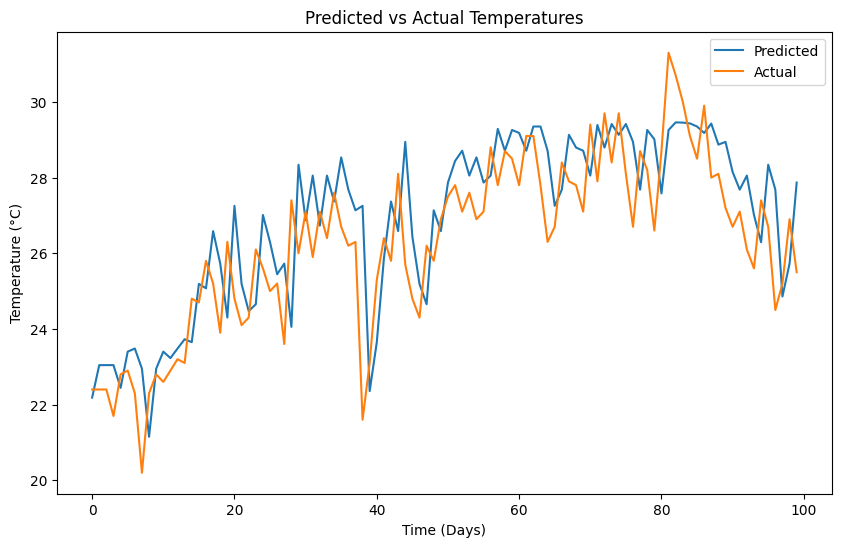

In [ ]:
import matplotlib.pyplot as plt

# Plot predicted vs actual values
plt.figure(figsize=(10,6))
plt.plot(predicted_temps[:100], label="Predicted")  # First 100 predicted values
plt.plot(actual_temps[:100], label="Actual")        # First 100 actual values
plt.title("Predicted vs Actual Temperatures")
plt.xlabel("Time (Days)")  # Label for x-axis
plt.ylabel("Temperature (°C)")  # Label for y-axis
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate Mean Absolute Error
mae = mean_absolute_error(actual_temps, predicted_temps)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Mean Squared Error
mse = mean_squared_error(actual_temps, predicted_temps)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate R-squared (R²)
r2 = r2_score(actual_temps, predicted_temps)
print(f"R-squared (R²): {r2}")

# Set a threshold (e.g., 2°C)
threshold = 2

# Calculate the percentage of predictions within the threshold
within_threshold = np.abs(actual_temps - predicted_temps) <= threshold
accuracy = np.mean(within_threshold) * 100
print(f"Accuracy within ±{threshold}°C: {accuracy:.2f}%")


Mean Absolute Error (MAE): 0.9064550995826721
Mean Squared Error (MSE): 1.3762952089309692
R-squared (R²): 0.7419320940971375
Accuracy within ±2°C: 91.63%
